In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yaml
import json

import tensorflow as tf

from pathlib import Path
from pymatgen.core import Structure
from sklearn.model_selection import train_test_split
from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph

import pymatgen
from collections import defaultdict
from tqdm.notebook import tqdm

from functions.prepare_data_and_sub import energy_within_threshold

2022-02-28 16:23:57.473850: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-28 16:23:57.473875: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/penchekrak/anaconda3/envs/idao2022/lib/python3.8/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/penchekrak/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")


In [2]:
def read_pymatgen_dict(file):
    with open(file, "r") as f:
        d = json.load(f)
    return Structure.from_dict(d)


def prepare_dataset(dataset_path, train=True):
    dataset_path = Path(dataset_path)
    struct = {
        item.name.strip(".json"): read_pymatgen_dict(item)
        for item in (dataset_path / "structures").iterdir()
    }

    data = pd.DataFrame(columns=["structures"], index=struct.keys())
    data = data.assign(structures=struct.values())
    if train:
        targets = pd.read_csv(dataset_path / "targets.csv", index_col=0)
        data = data.assign(targets=targets)

    return data

def decompose(structure):
    result = defaultdict(int)
    for site in structure.sites:
        result[site.species.formula] += 1
    return result

In [3]:
train = prepare_dataset('data/dichalcogenides_public/')
train['decomposition'] = train.structures.apply(decompose)
mask_list_train = [
            train['decomposition'] == defaultdict(int, {'Mo1': 63, 'W1': 1, 'Se1': 2, 'S1': 126}), #done
            train['decomposition'] == defaultdict(int, {'Mo1': 63, 'W1': 1, 'Se1': 1, 'S1': 126}), #done
            train['decomposition'] == defaultdict(int, {'Mo1': 63, 'Se1': 1, 'S1': 126}),
            train['decomposition'] == defaultdict(int, {'Mo1': 63, 'W1': 1, 'S1': 126}),
            train['decomposition'] == defaultdict(int, {'Mo1': 63, 'Se1': 2, 'S1': 126}),
            train['decomposition'] == defaultdict(int, {'Mo1': 63, 'S1': 126}),
            
    ]

train.head()

,structures,targets,decomposition
6141d16aee0a3fd43fb47ae1,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.4335,"{'Mo1': 63, 'Se1': 2, 'S1': 126}"
614256893ac25c70a5c6cb8b,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.4025,"{'Mo1': 63, 'S1': 126}"
6141fbefee0a3fd43fb47df5,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.4343,"{'Mo1': 63, 'Se1': 2, 'S1': 126}"
6141d57e9cbada84a8676983,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,1.8091,"{'Mo1': 63, 'W1': 1, 'Se1': 2, 'S1': 126}"
61424942ee0a3fd43fb47f21,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3560,"{'Mo1': 63, 'Se1': 2, 'S1': 126}"


# Class2

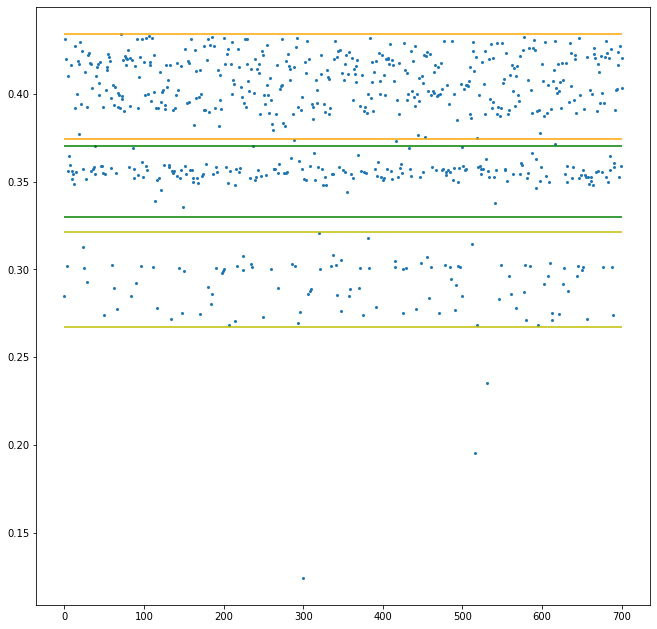

In [22]:
sample = train[mask_list_train[2]]

fig = plt.figure(figsize=(11,11))
plt.scatter(np.arange(len(sample)), sample.targets, s=4)

x = 0.434
plt.hlines(x, 0, 700, color='orange')
plt.hlines(x-0.06, 0, 700, color='orange')

x = 0.37
plt.hlines(x, 0, 700, color='green')
plt.hlines(x-0.04, 0, 700, color='green')

x = 0.321
plt.hlines(x, 0, 700, color='y')
plt.hlines(0.267, 0, 700, color='y')

# Class3


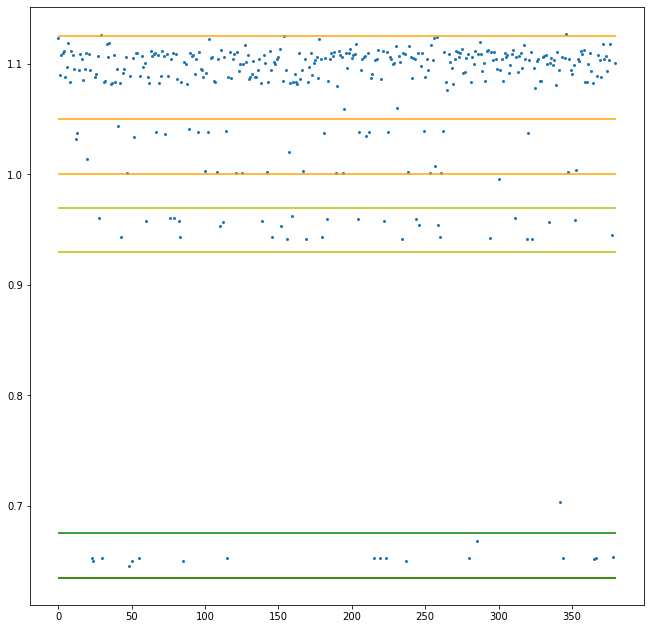

In [24]:
sample = train[mask_list_train[3]]

fig = plt.figure(figsize=(11,11))
plt.scatter(np.arange(len(sample)), sample.targets, s=4)

plt.hlines(1.1251, 0, 380, color='orange')
plt.hlines(1.0, 0, 380, color='orange')

plt.hlines(1.05, 0, 380, color='orange')
plt.hlines(x-0.04, 0, 380, color='orange')

x = 0.97
plt.hlines(x, 0, 380, color='y')
plt.hlines(x-0.04, 0, 380, color='y')

x = 0.675
plt.hlines(x, 0, 380, color='green')
plt.hlines(x-0.04, 0, 380, color='green')


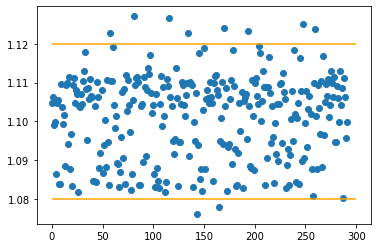

In [7]:
group1 = sample[(sample.targets > 1.07)].targets
plt.scatter(np.arange(len(group1)), group1)

x = 1.12
plt.hlines(x, 0, 300, color='orange')
plt.hlines(x-0.04, 0, 300, color='orange')

In [89]:
print(group1.mean(), group1.median())
energy_within_threshold(1.10*np.ones(len(group1)), group1)

1.1013304794520553 1.10425


0.9657534246575342

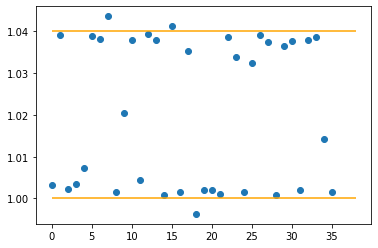

In [8]:
group2 = sample[(sample.targets < 1.05) & (sample.targets > 0.99)].targets
plt.scatter(np.arange(len(group2)), group2)

x = 1.04
plt.hlines(x, 0, 38, color='orange')
plt.hlines(x-0.04, 0, 38, color='orange')


In [99]:
print(group2.mean(), group2.median())
energy_within_threshold(1.02*np.ones(len(group2)), group2)

1.0208472222222222 1.0264


0.9166666666666666

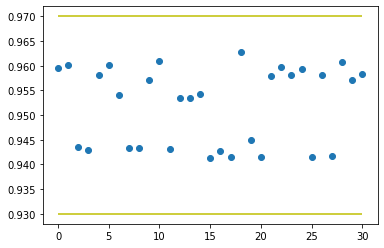

In [10]:
group3 = sample[(sample.targets < 0.975) & (sample.targets > 0.8)].targets
plt.scatter(np.arange(len(group3)), group3)

x = 0.97
plt.hlines(x, 0, 30, color='y')
plt.hlines(x-0.04, 0, 30, color='y')


In [132]:
print(group3.mean(), group3.median())
energy_within_threshold(0.95*np.ones(len(group3)), group3)

0.952109677419355 0.9542


1.0

In [15]:
energy_within_threshold(1.10*np.ones(len(group1)), group1), energy_within_threshold(1.02*np.ones(len(group2)), group2),energy_within_threshold(0.95*np.ones(len(group3)), group3) 

(0.9657534246575342, 0.9166666666666666, 1.0)

## Class 4

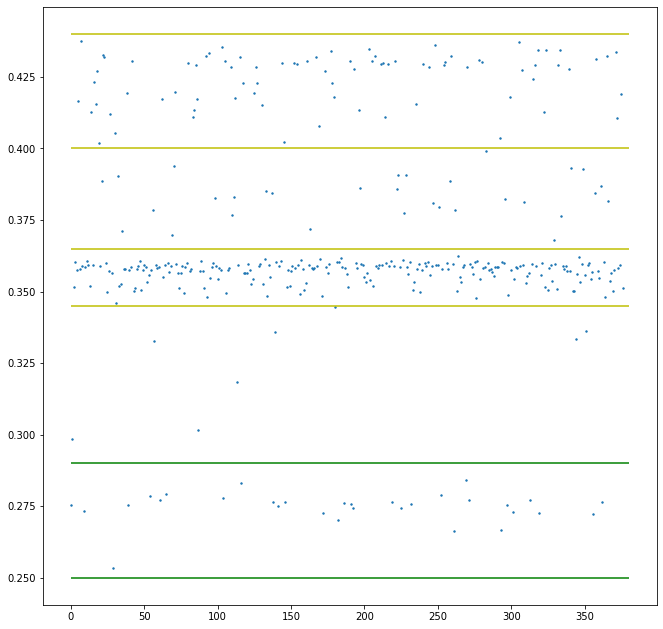

In [16]:
sample = train[mask_list_train[4]]

fig = plt.figure(figsize=(11,11))

plt.scatter(np.arange(len(sample)), sample.targets, s=2)

x = 0.44
plt.hlines(x, 0, 380, color='y')
plt.hlines(x-0.04, 0, 380, color='y')

# x = 0.393
# plt.hlines(x, 0, 380, color='orange')
# plt.hlines(x-0.025, 0, 380, color='orange')

x = 0.365
plt.hlines(x, 0, 380, color='y')
plt.hlines(x-0.02, 0, 380, color='y')

x = 0.29
plt.hlines(x, 0, 380, color='green')
plt.hlines(x-0.04, 0, 380, color='green')


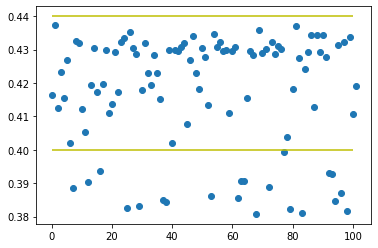

In [18]:
group1 = sample[(sample.targets > 0.38)].targets
plt.scatter(np.arange(len(group1)), group1)

x = 0.44
plt.hlines(x, 0, 100, color='y')
plt.hlines(x-0.04, 0, 100, color='y')

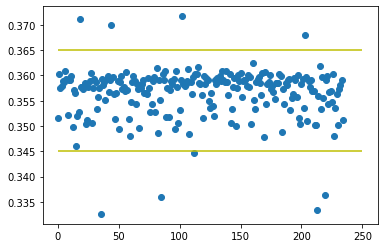

In [22]:
group2 = sample[(sample.targets < 0.375) & (sample.targets > 0.33)].targets
plt.scatter(np.arange(len(group2)), group2)

x = 0.365
plt.hlines(x, 0, 250, color='y')
plt.hlines(x-0.02, 0, 250, color='y')

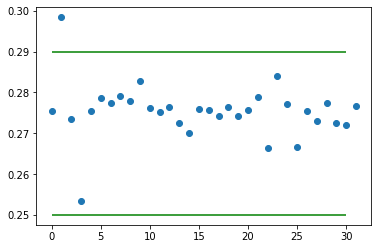

In [25]:
group3 = sample[(sample.targets < 0.3) & (sample.targets > 0.25)].targets
plt.scatter(np.arange(len(group3)), group3)

x = 0.29
plt.hlines(x, 0, 30, color='green')
plt.hlines(x-0.04, 0, 30, color='green')


In [26]:
energy_within_threshold(0.42*np.ones(len(group1)), group1), energy_within_threshold(0.345*np.ones(len(group2)), group2),energy_within_threshold(0.27*np.ones(len(group3)), group3) 

(0.7941176470588235, 0.9829787234042553, 0.96875)

## Сlass5

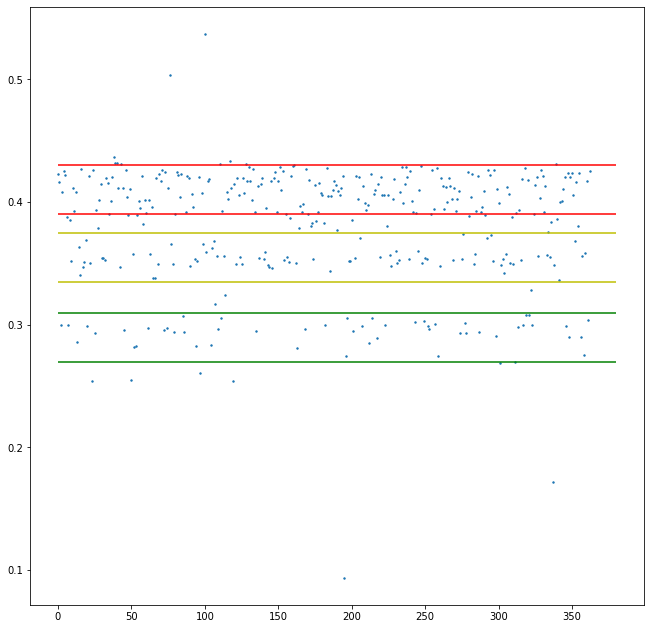

In [32]:
sample = train[mask_list_train[5]].copy()
fig = plt.figure(figsize=(11,11))

plt.scatter(np.arange(len(sample)), sample.targets, s=2)

x = 0.43
plt.hlines(x, 0, 380, color='red')
plt.hlines(x-0.04, 0, 380, color='red')

x = 0.375
plt.hlines(x, 0, 380, color='y')
plt.hlines(x-0.04, 0, 380, color='y')

x = 0.31
plt.hlines(x, 0, 380, color='green')
plt.hlines(x-0.04, 0, 380, color='green')

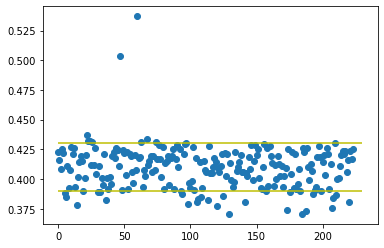

In [49]:
group1 = sample[(sample.targets > 0.37)].targets
plt.scatter(np.arange(len(group1)), group1)

x = 0.43
plt.hlines(x, 0, 230, color='y')
plt.hlines(x-0.04, 0, 230, color='y')

In [54]:
print(group1.mean(), group1.median())
energy_within_threshold(0.409*np.ones(len(group1)), group1)

0.4095924107142857 0.41114999999999996


0.8392857142857143

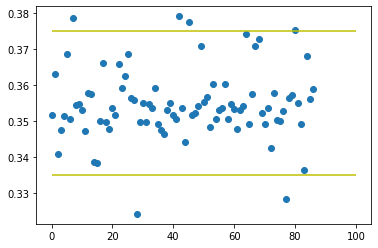

In [55]:
group2 = sample[(sample.targets < 0.38) & (sample.targets > 0.32)].targets
plt.scatter(np.arange(len(group2)), group2)

x = 0.375
plt.hlines(x, 0, 100, color='y')
plt.hlines(x-0.04, 0, 100, color='y')


In [59]:
print(group2.mean(), group2.median())
energy_within_threshold(0.355*np.ones(len(group2)), group2)

0.3545425287356322 0.3535


0.9310344827586207

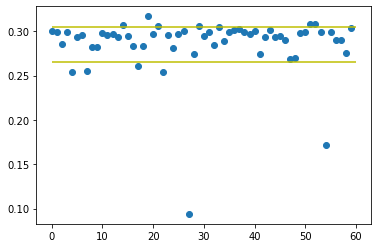

In [67]:
group3 = sample[(sample.targets < 0.32)].targets
plt.scatter(np.arange(len(group3)), group3)

x = 0.305
plt.hlines(x, 0, 60, color='y')
plt.hlines(x-0.04, 0, 60, color='y')


In [69]:
print(group3.mean(), group3.median())
energy_within_threshold(0.295*np.ones(len(group3)), group3)

0.2864583333333333 0.29564999999999997


0.8166666666666667

In [70]:
energy_within_threshold(0.409*np.ones(len(group1)), group1), energy_within_threshold(0.355*np.ones(len(group2)), group2),energy_within_threshold(0.295*np.ones(len(group3)), group3) 

(0.8392857142857143, 0.9310344827586207, 0.8166666666666667)

In [72]:
sum(mask_list_train[3]), sum(mask_list_train[4]), sum(mask_list_train[5])

(380, 377, 363)